In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import kagglehub
import os
from torch.utils.data import DataLoader

In [19]:
class CNN_FacialExpression(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_FacialExpression, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128*6*6, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # Pass through the convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128*6*6)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [10]:
path = "/1"
model = CNN_FacialExpression(num_classes=7)

In [22]:
# Path to the dataset
dataset_path = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1")

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(),                # ensure 1 channel
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load training and test datasets
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FacialExpression(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save model after each epoch
    model_path = f"./cnn_fer_epoch.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Epoch [1/20], Loss: 1.6755
Model saved to ./cnn_fer_epoch.pth
Epoch [2/20], Loss: 1.4180
Model saved to ./cnn_fer_epoch.pth
Epoch [3/20], Loss: 1.2697
Model saved to ./cnn_fer_epoch.pth
Epoch [4/20], Loss: 1.1484
Model saved to ./cnn_fer_epoch.pth
Epoch [5/20], Loss: 1.0396
Model saved to ./cnn_fer_epoch.pth
Epoch [6/20], Loss: 0.9203
Model saved to ./cnn_fer_epoch.pth
Epoch [7/20], Loss: 0.7952
Model saved to ./cnn_fer_epoch.pth
Epoch [8/20], Loss: 0.6610
Model saved to ./cnn_fer_epoch.pth
Epoch [9/20], Loss: 0.5155
Model saved to ./cnn_fer_epoch.pth
Epoch [10/20], Loss: 0.3813
Model saved to ./cnn_fer_epoch.pth
Epoch [11/20], Loss: 0.2724
Model saved to ./cnn_fer_epoch.pth
Epoch [12/20], Loss: 0.1865
Model saved to ./cnn_fer_epoch.pth
Epoch [13/20], Loss: 0.1344
Model saved to ./cnn_fer_epoch.pth
Epoch [14/20], Loss: 0.1080
Model saved to ./cnn_fer_epoch.pth
Epoch [15/20], Loss: 0.1003
Model saved to ./cnn_fer_epoch.pth
Epoch [16/20], Loss: 0.0866
Model saved to ./cnn_fer_epoch.pth
E

/tmp/ipykernel_5090/2001924115.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))


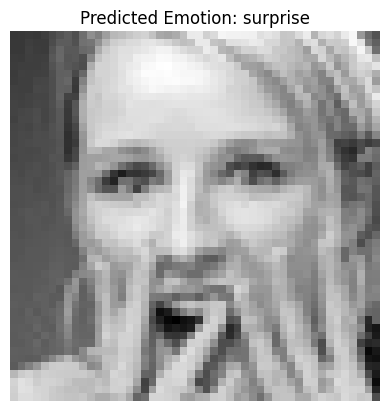

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

model = CNN_FacialExpression(num_classes=7).to(device)
model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])


image_path = "1/test/surprise/PrivateTest_10775220.jpg" 
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output.data, 1)

class_labels = train_dataset.classes
predicted_emotion = class_labels[predicted_class.item()]

plt.imshow(image.convert("L"), cmap="gray")
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

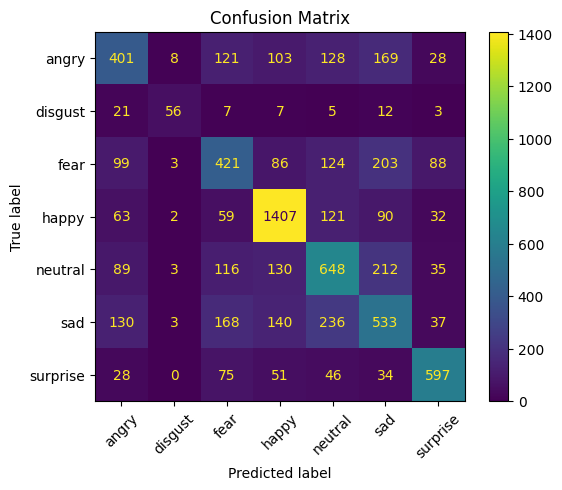

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [34]:
model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


/tmp/ipykernel_5090/1089905480.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))


tensor([5, 0, 5, 0, 0, 2, 4, 0, 3, 0, 2, 3, 0, 5, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0,
        4, 3, 0, 1, 4, 0, 3, 5, 5, 0, 4, 4, 0, 3, 5, 0, 0, 5, 5, 2, 2, 0, 0, 4,
        0, 4, 2, 0, 0, 2, 2, 4, 3, 0, 5, 5, 2, 5, 0, 3])
tensor([6, 0, 0, 0, 0, 2, 0, 0, 2, 4, 6, 0, 0, 0, 5, 0, 1, 0, 4, 0, 0, 4, 0, 0,
        0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0, 4, 5, 3, 0, 2, 3, 5, 2,
        5, 0, 4, 0, 1, 2, 0, 1, 5, 4, 0, 2, 3, 0, 0, 0])
tensor([0, 2, 0, 0, 0, 0, 4, 2, 4, 5, 0, 0, 2, 0, 2, 4, 6, 4, 2, 4, 3, 0, 5, 0,
        0, 0, 5, 3, 0, 0, 0, 5, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 2, 6, 0, 5,
        0, 3, 4, 6, 4, 0, 5, 0, 2, 4, 0, 0, 2, 4, 4, 3])
tensor([0, 5, 5, 5, 0, 2, 4, 0, 5, 2, 3, 2, 3, 4, 3, 0, 0, 3, 2, 0, 0, 0, 4, 0,
        0, 0, 5, 0, 0, 0, 0, 5, 0, 2, 0, 3, 5, 4, 0, 3, 4, 5, 5, 2, 3, 5, 3, 4,
        3, 2, 3, 3, 4, 0, 5, 2, 0, 4, 4, 6, 2, 0, 0, 0])
tensor([3, 0, 0, 5, 5, 0, 3, 5, 3, 0, 0, 3, 5, 4, 5, 0, 2, 5, 5, 4, 0, 2, 6, 2,
        5, 0, 3, 3, 5, 0, 0, 3, 0, 3, 0, 0, 4, 0, 0,